In [5]:
import os
from tqdm.auto import tqdm
import sys
sys.path.insert(0, '../')
import util.util_diffengine_parsing as udp
import util.util_newssniffer_parsing as unp
import sqlite3
import pandas as pd 
import difflib
from IPython.core.display import display, HTML
import pickle
import matplotlib.pyplot as plt
plt.rc('font', size=14)
import numpy as np
from importlib import reload
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import pycountry

In [2]:
if False:
    pd.read_sql("""
        SELECT 
            name
        FROM 
            sqlite_master 
        WHERE 
            type ='table' AND 
            name NOT LIKE 'sqlite_%';
    """, con=conn_dict[name])

to_examine = [
    ## diffengine
    'dailymail.db',
    'ap.db',
#     'bbc.db',
    'cbc.db',
    'fox.db',
    'reuters.db',
    'cnn.db',
    'torontosun.db',
#     ## newssniffer
    'newssniffer-bbc.db',
    'newssniffer-guardian.db',
    'newssniffer-independent.db',
    'newssniffer-nytimes.db',
    'newssniffer-washpo.db',
]

In [3]:
db_path = '../data/diffengine-diffs/db/'
conn_dict = {}
diffs_dict = {}
entry_vers_dict = {}
for db in tqdm(to_examine):
    print(db)
    name = db.replace('.db', '')
    conn_dict[name] = sqlite3.connect(os.path.join(db_path, db))
#     diffs_dict[name] = pd.read_sql('select * from diff', con=conn_dict[name])
    entry_vers_dict[name] = pd.read_sql("""
        SELECT id, title, summary, created, url, entry_id, archive_url, num_versions from entryversion
        where num_versions < 30
        limit 1000
    """, con=conn_dict[name])

  0%|          | 0/12 [00:00<?, ?it/s]

dailymail.db
ap.db
cbc.db
fox.db
reuters.db
cnn.db
torontosun.db
newssniffer-bbc.db
newssniffer-guardian.db
newssniffer-independent.db
newssniffer-nytimes.db
newssniffer-washpo.db


In [76]:
list(entry_vers_dict.values())[0].head(2)

,id,title,summary,created,url,entry_id,archive_url,num_versions
0,1,Supreme Court ruling TUESDAY on if MPs must vo...,<p> The Supreme Court will rule on Tuesday whe...,2017-01-18 15:06:34.200627,http://www.dailymail.co.uk/news/article-413235...,1,https://wayback.archive.org/web/20170118150655...,2
1,2,Range Rover hit-and-run kills woman near Houns...,<p>The first pictures have emerged of the vict...,2017-01-18 15:06:38.398975,http://www.dailymail.co.uk/news/article-413127...,2,https://wayback.archive.org/web/20170118150658...,3


# Get Summary Statistics

## Number articles/versions per source

In [ ]:
article_counts = {}
for n, conn in tqdm(conn_dict.items()):
    c = pd.read_sql('select Count(1) from entry', con=conn).iloc[0][0]
    article_counts[n] = c

version_counts = {}
for n, conn in tqdm(conn_dict.items()):
    c = pd.read_sql('select Count(1) from entryversion', con=conn).iloc[0][0]
    version_counts[n] = c

article_counts = pd.Series(article_counts)
version_counts = pd.Series(version_counts)

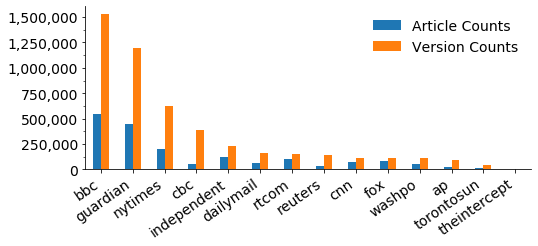

In [54]:
article_and_version_count_df = pd.concat([
    pd.Series(article_counts).to_frame('article_counts'),
    pd.Series(version_counts).to_frame('version_counts'),
], axis=1)


ax = article_and_version_count_df.sort_values('version_counts').iloc[::-1].plot(kind='bar', figsize=(8,3))

plt.legend(['Article Counts', 'Version Counts'], frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=35, horizontalalignment='right')

ax.yaxis.set_major_locator(MultipleLocator(250000))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_minor_locator(MultipleLocator(125000))

## Number of versions per article

In [62]:
all_entry_vs = []
for n, conn in tqdm(conn_dict.items()):
    entry_vs = pd.read_sql('select count(1) as version_counts from entryversion group by entry_id', con=conn)
    entry_vs['source'] = n
    all_entry_vs.append(entry_vs)

  0%|          | 0/7 [00:00<?, ?it/s]

In [79]:
all_entry_vs_df = pd.concat(all_entry_vs)

In [89]:
grouped = (
    all_entry_vs_df
        .groupby('source')
        .median()
        .sort_values(by='version_counts', ascending=False)
)

Text(0, 0.5, '')

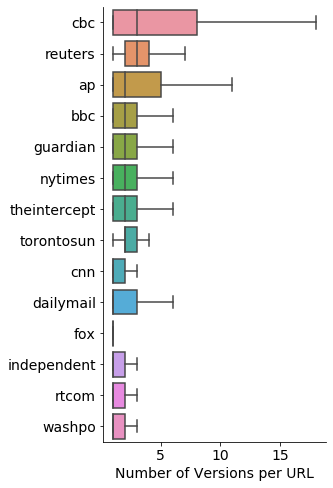

In [96]:
f, ax = plt.subplots(figsize=(4, 8))

ax = sns.boxplot(
    data=all_entry_vs_df,# .sort_values('version_counts'),
    x='version_counts',
    y='source',
    showfliers=False,
    order=grouped.index,
    ax=ax
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Number of Versions per URL')
plt.ylabel('')

## Collect different diffs and annotate sentence-change/word change statistics

In [6]:
conn_dict

{'dailymail': <sqlite3.Connection at 0x7fe5bb674110>,
 'ap': <sqlite3.Connection at 0x7fe5bbf89730>,
 'cbc': <sqlite3.Connection at 0x7fe5bc860810>,
 'fox': <sqlite3.Connection at 0x7fe5bc90c9d0>,
 'reuters': <sqlite3.Connection at 0x7fe5bca48490>,
 'cnn': <sqlite3.Connection at 0x7fe5bcc09810>,
 'torontosun': <sqlite3.Connection at 0x7fe5bcc82570>,
 'newssniffer-bbc': <sqlite3.Connection at 0x7fe5bcc823b0>,
 'newssniffer-guardian': <sqlite3.Connection at 0x7fe5bcc82810>,
 'newssniffer-independent': <sqlite3.Connection at 0x7fe5a0c449d0>,
 'newssniffer-nytimes': <sqlite3.Connection at 0x7fe5a0f63810>,
 'newssniffer-washpo': <sqlite3.Connection at 0x7fe5a28182d0>}

In [7]:
# for name, conn in conn_dict.items():
nyt_conn = sqlite3.connect('../data/diffengine-diffs/db/newssniffer-nytimes.db')
sample_nyt_diffs = pd.read_sql("""
    SELECT * from entryversion 
    WHERE entry_id IN (SELECT DISTINCT entry_id from entryversion ORDER BY RANDOM() LIMIT 100)
""", con=nyt_conn)

In [14]:
reload(unp)

<module 'util.util_newssniffer_parsing' from '../util/util_newssniffer_parsing.py'>

In [ ]:
sentence_stats_df, words_stats_df = unp.get_sentence_diff_stats(
    sample_nyt_diffs, 
    get_word_diff=True, 
    get_sentence_vars=True
)

  0%|          | 0/100 [00:00<?, ?it/s]

[]

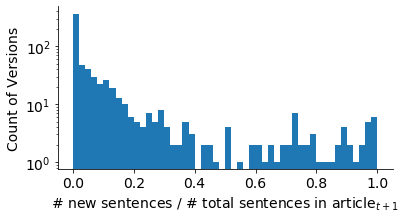

In [676]:
import matplotlib.pyplot as plt
ax = (sentence_stats_df
 .pipe(lambda df: df['num_added_sents'] / (df['len_new_doc']))
 .hist(bins=50, figsize=(6, 3))
)
plt.grid(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('Count of Versions')
plt.xlabel('# new sentences / # total sentences in article$_{t+1}$')
plt.semilogy()

[]

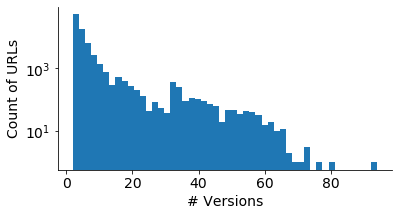

In [712]:
reut_versions_per_article = pd.read_sql('select entry_id, Count(1) from entryversion group by entry_id', con=conn_dict['reuters'])

ax = nyt_versions_per_article['Count(1)'].hist(bins=50, figsize=(6, 3))
plt.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('Count of URLs')
plt.xlabel('# Versions')

plt.semilogy()